In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt



%matplotlib inline

c:\Users\olive\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\olive\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\olive\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [18]:
#!pip install --upgrade google-cloud-bigquery

In [2]:
from google.cloud import bigquery


In [3]:

from google.oauth2 import service_account


### Run simple single series examples with 
* Simple Exponential smoothing (select alpha automaticall)
* Holts Winters
* Holts Winters Seasonally Adjusted

### Data 
Data will be from IOWA liquor sales.<br>
https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy

**Transformation**: aggregated total sales by store by week from 2018 to 2022. Pick top 100 stores by sales for this period.



In [4]:

credentials = service_account.Credentials.from_service_account_file(
'big_query.json')

project_id = 'u4cast-cr'
client = bigquery.Client(credentials= credentials,project=project_id)

**Load Data**

In [6]:
query = """SELECT * FROM `u4cast-cr.finance_data.historical_sales` """
df = client.query(query).to_dataframe()

df.head()


ValueError: Please install the 'db-dtypes' package to use this function.

In [50]:
df.date = pd.to_datetime(df.date)

**Pop off just one sereies**
* Then just use volumne

In [51]:
sdf = df[(df['county'] =='LINN') & (df['category'] == 'american vodkas')]

In [52]:
sdf = sdf[['date','total_amount_sold']]

In [53]:
sdf.dtypes

date                 datetime64[ns]
total_amount_sold             int64
dtype: object

In [54]:
sdf.set_index('date',inplace=True)
# index = pd.date_range(start="2005", end="2010-Q4", freq="QS-OCT")
# aust = pd.Series(data, index)

In [55]:
fit1 = ExponentialSmoothing(sdf,
    seasonal_periods = 12,
    trend='add',seasonal='add',
    use_boxcox=True,
    initialization_method='estimated',).fit()

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:xlabel='date'>

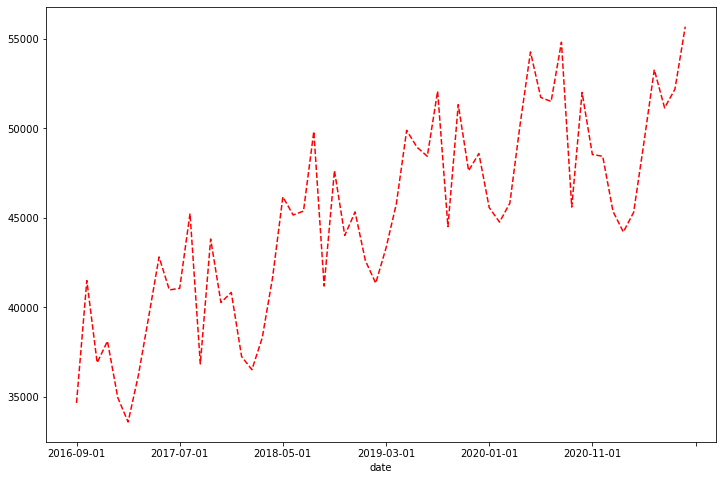

In [34]:
#type(fit1.fittedvalues)
#fit1.fittedvalues.plot()

fig, ax = plt.subplots(figsize=(12,8))
fit1.fittedvalues.plot(ax=ax, style="--", color="red")

In [40]:
pd.DataFrame(fit1.fittedvalues).head()

,0
date,
2016-09-01,34656.397962
2016-10-01,41498.048116
2016-11-01,36907.718046
2016-12-01,38108.936484
2017-01-01,34956.680478


C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:>

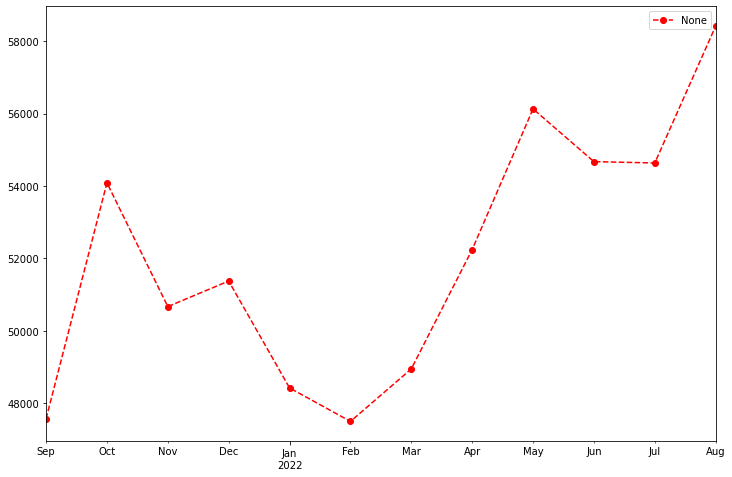

In [35]:

fig, ax = plt.subplots(figsize=(12,8))
#fit1.fittedvalues.index
ax.plot()
# fit1.forecast(12).plot(ax=ax, style="--", marker="o", color="red", legend=True
# )
#fit1.fittedvalues.plot(ax=ax, style="--", color="red")
#fit1.forecast(12).plot()


In [57]:
type(fit1.fittedvalues.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [56]:
type(fit1.forecast(12).index
)

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


pandas.core.indexes.datetimes.DatetimeIndex

C:\Users\olive\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='date'>

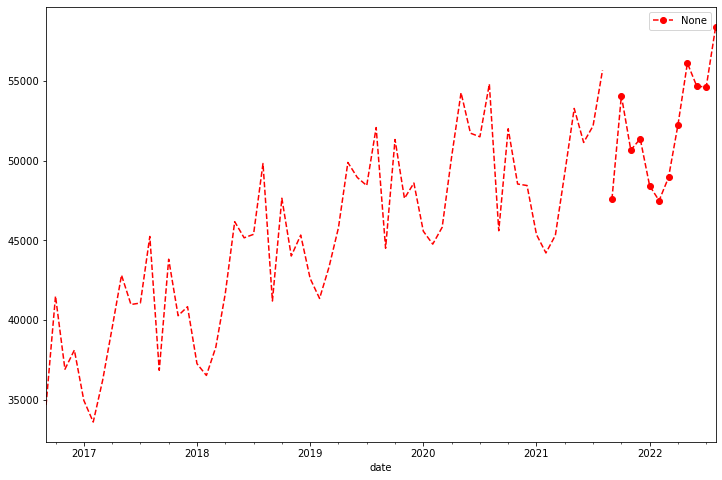

In [58]:
# ax = sdf.plot(
#     figsize=(10, 6),
#     marker="o",
#     color="black",
#     title="Forecasts from Holt-Winters' additive method",
# )

fig, ax = plt.subplots(figsize=(12,8))

fit1.fittedvalues.plot(ax=ax, style="--", color="red")
fit1.forecast(12).plot(ax=ax, style="--", marker="o", color="red", legend=True
)

## Create a data from from results